# Bank Marketing Predictions

Dataset retrieved from [Kaggle](https://www.kaggle.com/henriqueyamahata/bank-marketing)

This dataset is filled with outcomes of marketing campaign phone calls from a Portuguese banking institution. Each phone call has a target to get the customer to subscribe to a term deposit at a bank institution. This is what we will be training the model to predict, so this is a binary classification problem.

Having a trained model to be able to predict whether a customer will subscribe or not can be really beneficial for sales representatives. They can prioritize individuals who are more likely to subscribe.

Some attributes of the dataset that we will have to handle are that there is a lot of categorical features that will need to be encoded along with an imbalance between the two binary classifiers across the dataset.

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Model Helpers
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.utils import resample

## Data Analysis

The data is well prepared with no null values. The biggest thing that needs to be tackled is encoding of categorical features and handling the imbalanced dataset.

In [2]:
data = pd.read_csv('bank-marketing.csv')
pd.options.display.max_columns = None
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Here's the age distribution of the callers. Visualization code retrieved from [here](https://www.kaggle.com/henriqueyamahata/bank-marketing-classification-roc-f1-recall).

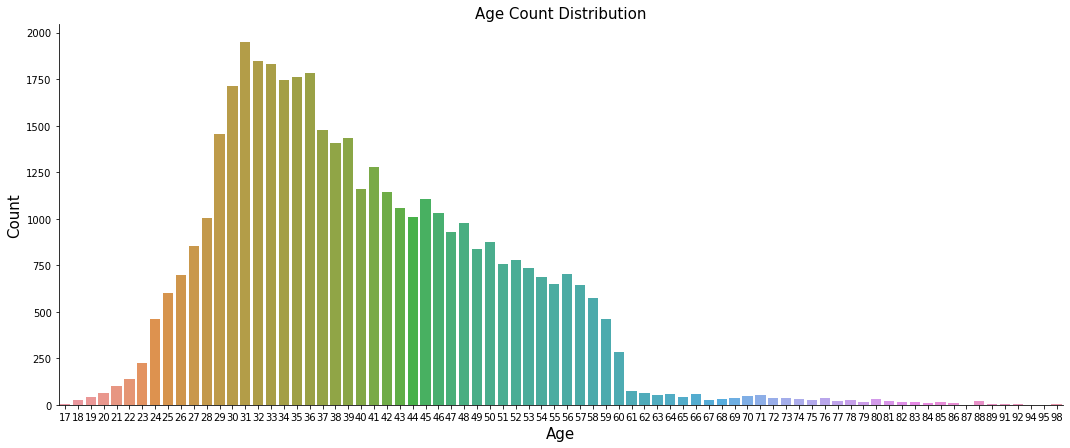

In [4]:
age = data.sort_values('age')
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
sns.countplot(x = 'age', data = data.sort_values('age'))
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Age Count Distribution', fontsize=15)
sns.despine()

Here's the distribution of marital status.

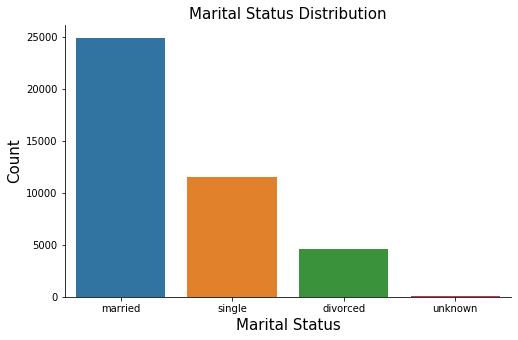

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.countplot(x = 'marital', data = data, order=data['marital'].value_counts().index)
ax.set_xlabel('Marital Status', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Marital Status Distribution', fontsize=15)
sns.despine()

Here's the distribution of education levels.

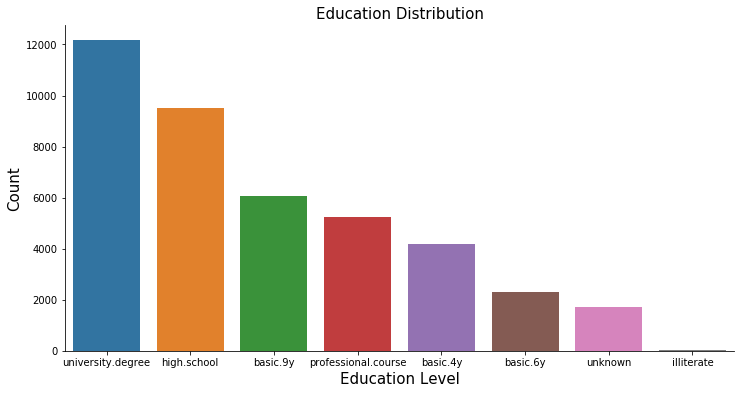

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
sns.countplot(x = 'education', data = data.sort_values('education'), order=data['education'].value_counts().index)
ax.set_xlabel('Education Level', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Education Distribution', fontsize=15)
sns.despine()

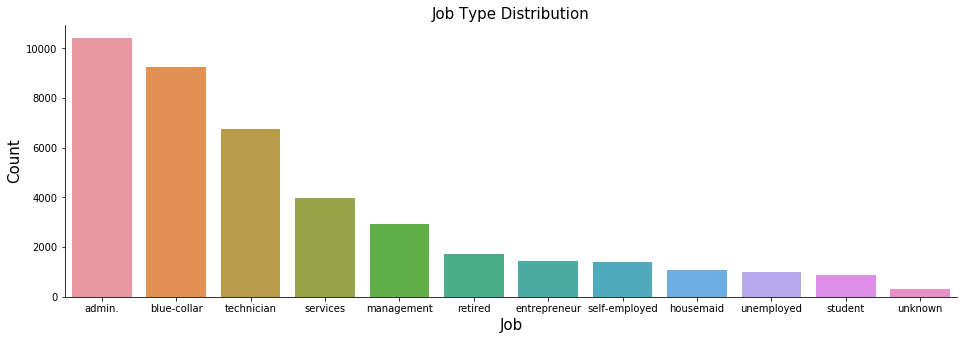

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.countplot(x = 'job', data = data, order=data['job'].value_counts().index)
ax.set_xlabel('Job', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Job Type Distribution', fontsize=15)
sns.despine()

#### Distribution of Subscribed Customers on Each Day of The Week

One of the main takeaways I noticed from the chart below is it seems that people are much less likely to subscribe to bank term deposits on Monday.

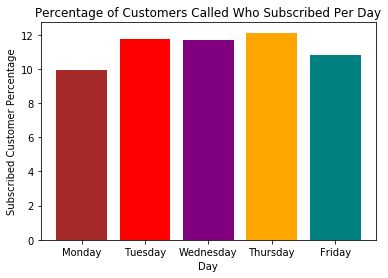

In [8]:
y_class = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

plt.bar(y_class, [(np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'mon')) 
                   / np.sum(data['day_of_week'] == 'mon')) * 100, 
                  (np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'tue')) 
                   / np.sum(data['day_of_week'] == 'tue')) * 100,
                  (np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'wed')) 
                   / np.sum(data['day_of_week'] == 'wed')) * 100,
                  (np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'thu')) 
                   / np.sum(data['day_of_week'] == 'thu')) * 100,
                  (np.sum((data['y'] == 'yes') & (data['day_of_week'] == 'fri')) 
                   / np.sum(data['day_of_week'] == 'fri')) * 100],
                color=['brown', 'red', 'purple', 'orange', 'teal'])
plt.xlabel("Day")
plt.ylabel("Subscribed Customer Percentage")
plt.title("Percentage of Customers Called Who Subscribed Per Day")
plt.show()

#### Distribution of Subscribed and Non Subscribed Customers

As you can visually see, the dataset is very skewed. If the data is run through a model without being stratified, it will cause us to get improper accuracy results, as about 90% of client phone calls in the dataset did not subscribe.

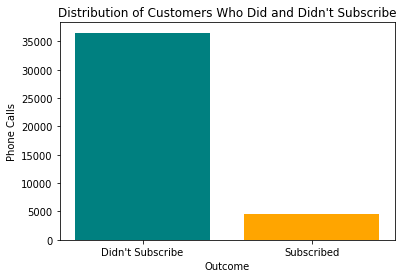

In [9]:
y_class = ['Didn\'t Subscribe', 'Subscribed']

plt.bar(y_class, [np.sum(data['y'] == 'no'), np.sum(data['y'] == 'yes')], color=['teal', 'orange'])
plt.xlabel("Outcome")
plt.ylabel("Phone Calls")
plt.title("Distribution of Customers Who Did and Didn't Subscribe")
plt.show()

## Data Engineering

First, I will bin certain categorical features to try and simplify the dataset for better learning. The age and duration function code snippets I retrieved from [here](https://www.kaggle.com/henriqueyamahata/bank-marketing-imbalanced-dataset-94).

In [10]:
bin_education = {
    "university.degree": "university.degree",
    "professional.course": "professional.course",
    "high.school": "high.school",
    "basic.9y": "basic",
    "basic.6y": "basic",
    "basic.4y": "basic",
    "unknown": "unknown",
    "illiterate": "unknown"
}
data.education = data.education.map(bin_education)

def age(dataframe):
    dataframe.loc[dataframe['age'] <= 32, 'age'] = 1
    dataframe.loc[(dataframe['age'] > 32) & (dataframe['age'] <= 47), 'age'] = 2
    dataframe.loc[(dataframe['age'] > 47) & (dataframe['age'] <= 70), 'age'] = 3
    dataframe.loc[(dataframe['age'] > 70) & (dataframe['age'] <= 98), 'age'] = 4
           
    return dataframe

data = age(data)

def duration(data):

    data.loc[data['duration'] <= 102, 'duration'] = 1
    data.loc[(data['duration'] > 102) & (data['duration'] <= 180)  , 'duration']    = 2
    data.loc[(data['duration'] > 180) & (data['duration'] <= 319)  , 'duration']   = 3
    data.loc[(data['duration'] > 319) & (data['duration'] <= 644.5), 'duration'] = 4
    data.loc[data['duration']  > 644.5, 'duration'] = 5

    return data

data = duration(data)

Now, I am applying a form of one hot encoding to categorical features.

In [11]:
data = pd.get_dummies(data, columns=['job'], prefix = ['job'])
data = pd.get_dummies(data, columns=['marital'], prefix = ['marital'])
data = pd.get_dummies(data, columns=['education'], prefix = ['education'])
data = pd.get_dummies(data, columns=['default'], prefix = ['default'])
data = pd.get_dummies(data, columns=['housing'], prefix = ['housing'])
data = pd.get_dummies(data, columns=['loan'], prefix = ['loan'])
data = pd.get_dummies(data, columns=['contact'], prefix = ['contact'])
data = pd.get_dummies(data, columns=['month'], prefix = ['month'])
data = pd.get_dummies(data, columns=['day_of_week'], prefix = ['day_of_week'])
data = pd.get_dummies(data, columns=['poutcome'], prefix = ['poutcome'])

The number of days since last call feature has a value of 999 if the customer hasn't been called before. This can possibly create unwanted bias. Instead of setting a wild number that has an unknown purpose, 999 should be set to 0 and a new featured named 'called_before' should be created that will be a boolean value.

In [12]:
data['called_before'] = data.pdays.apply(lambda row: 0 if (row == 999) else 1)
data['pdays'] = data.pdays.apply(lambda row: 0 if (row == 999) else row)

The target column is currently either 'yes' or 'no' strings. That can't be fed into the model, so it should be encoded to 1 or 0.

In [13]:
data['y'] = data.y.apply(lambda row: 1 if (row == 'yes') else 0)

## Create Training and Test Sets

There are a total of 4,640 samples out of 41,188 samples where clients have subscribed to bank term deposits. I will use a form of resampling to oversample the clients who have subscribed which will in return double our amount of subscribed samples. To properly train the model, the training set and test set will both be stratified in a 80/20 split. This means that 80% of the non-subscribed and subscribed samples will be used for training and 20% will be used for testing. That allows for the model to properly learn from the dataset and allow us to see true performance metrics, as the two sets will be properly stratified.

Divide up the data based on its predetermined label and assign to variables for easy management and also randomize each labeled variable to give the model a variety of inputs. I decided to double the subscribed section of the dataset when resampling, as I didn't want to overfit the models with too many synthetic samples.

In [14]:
X_not_sub, X_sub = data[data.y == 0], data[data.y == 1]

# Resample the subscribed samples
X_sub = resample(X_sub, replace=True, n_samples=int(4640*2), random_state=123) 
y_not_sub, y_sub = X_not_sub.pop('y'), X_sub.pop('y')

X = X_not_sub.append(X_sub)
y = y_not_sub.append(y_sub)

print("Not subscribed: %s \t Subscribed: %s" % (X_not_sub.shape[0], X_sub.shape[0]))

Not subscribed: 36548 	 Subscribed: 9280


#### Sets for Random Forest and Logistic Regression

Random Forest doesn't require scaled data and isn't going to use PCA. Logistic Regression requires data to be scaled, and we will be using PCA as well to see if there are any benefits. Initially, I wasn't shuffling the two sets, so I was getting bad performance measures when testing models. This was happening because the test data was completely different to what the model had trained on, so once I added the shuffling, it cleared up and performed much better.

In [15]:
# Random Forest Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

# Logistic Regression Sets
sc = StandardScaler() #center the distribution around zero (mean), with a standard deviation of 1.
sc.fit(X)
X_std = sc.transform(X)

X_pca = PCA(0.99, svd_solver='full').fit_transform(X_std)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_std, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)
X_pca.shape

(45828, 45)

## Train the Model

### Random Forest Model

First, we will be using the Random Forest model accompanied with GridSearchCV to help find the optimal hyper-parameters when fitting the model. We then will test the model's performance using accuracy, precision, recall, the AUC derived from the ROC curve, the sum of samples that were misclassified, and also an overall classification report.

#### Training the model

In [16]:
rnd_clf = RandomForestClassifier(random_state=42, n_estimators=100)

Setup the GridSearchCV parameters and fit the model on them.

In [17]:
rnd_params = [
   { 
     'max_depth': [None, 2, 4, 6, 8, 10, 12], 
     'min_samples_leaf' : [1, 2, 3, 4, 5],
     'max_leaf_nodes': [None, 4, 8, 12, 14],
   },
]

rnd_cv = GridSearchCV(estimator=rnd_clf, param_grid=rnd_params, cv=4)
rnd_cv.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'ma

In [18]:
print('Optimal params: {}'.format(rnd_cv.best_estimator_))

Optimal params: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


Code below retrieved from [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html). This is showing the feature importance after the model has been trained. It showed in descending order which features had the most impact on predicting. This was very insightful to see, as I originally was using it to drop specific features that I didn't need. However, I found that when I dropped unimportant features, the learning performance measure would go down. For that reason and the fact that there isn't a huge amount of features, I opted to not drop any features during the data engineering phase.

Feature ranking:
Feature: age, Index: 1 (0.231255)
Feature: duration, Index: 8 (0.127119)
Feature: campaign, Index: 2 (0.051628)
Feature: pdays, Index: 9 (0.048053)
Feature: previous, Index: 5 (0.037153)
Feature: emp.var.rate, Index: 0 (0.033968)
Feature: cons.price.idx, Index: 7 (0.025603)
Feature: cons.conf.idx, Index: 6 (0.023531)
Feature: euribor3m, Index: 3 (0.020933)
Feature: nr.employed, Index: 59 (0.020139)


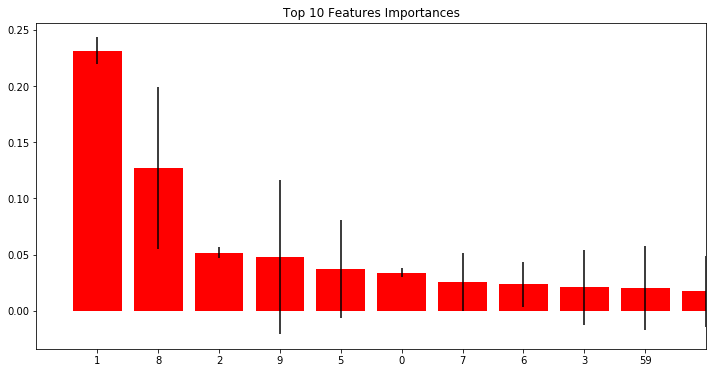

In [19]:
importances = rnd_cv.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rnd_cv.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


#for name, importance in zip(X_train, rnd_cv.best_estimator_.feature_importances_):
#    print(name, "=", importance)

for f in range(10):
    print("Feature: %s, Index: %d (%f)" % (X_train.columns[f], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12, 6))
plt.title("Top 10 Features Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

Calculate the cross validation score on the training data prior to testing on unseen data.

In [20]:
cross_val_score(rnd_cv, X_train, y_train, cv=3, scoring="accuracy")

array([0.92823828, 0.92594714, 0.92618658])

#### Testing on unseen data

Compute the accuracy, precision, and recall on the test data.

In [21]:
y_pred = rnd_cv.predict(X_test)

print("Accuracy score: ", (accuracy_score(y_test, y_pred)))
print("Precision score: ", (precision_score(y_test, y_pred)))
print("Recall score: ", (recall_score(y_test, y_pred)))

Accuracy score:  0.9461051712851843
Precision score:  0.8474489795918367
Recall score:  0.8949353448275862


Compute the AUC value.

In [22]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area under the curve: {}'.format(roc_auc))

Area under the curve: 0.9270162360252843


In [23]:
print('Misclassified samples: ' + str((y_test != y_pred).sum()))

Misclassified samples: 494


In [24]:
print('Random Forest Report\n',classification_report(y_test, y_pred))

Random Forest Report
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      7310
           1       0.85      0.89      0.87      1856

    accuracy                           0.95      9166
   macro avg       0.91      0.93      0.92      9166
weighted avg       0.95      0.95      0.95      9166



### Logistic Regression Model

Next, we will try the Logistic Regression model using GridSearchCV to automate hyper-parameters. We then will test the model's performance using accuracy, precision, recall, the AUC derived from the ROC curve, the sum of samples that were misclassified, and also an overall classification report.

#### Training the model

In [25]:
lr_clf = LogisticRegression(solver="lbfgs", random_state=42, max_iter=1000)

Calculate the cross validation score on the training data prior to testing on unseen data.

Setup the GridSearchCV parameters and fit the model on them.

In [26]:
lr_params = [
   { 
        'max_iter': [500, 1000, 1500],
        'solver': ['lbfgs', 'liblinear']
   },
]

lr_cv = GridSearchCV(estimator=lr_clf, param_grid=lr_params, cv=4)
lr_cv.fit(X_train_pca, y_train_pca)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_iter': [500, 1000, 1500],
                          'solver': ['lbfgs', 'liblinear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [27]:
print('Optimal params: {}'.format(lr_cv.best_estimator_))

Optimal params: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


Calculate the cross validation score on the training data prior to testing on unseen data.

In [28]:
cross_val_score(lr_cv.best_estimator_, X_train_pca, y_train_pca, cv=3, scoring="accuracy")

array([0.87734228, 0.87513297, 0.87201309])

#### Testing on unseen data

Compute the accuracy, precision, and recall on the test data.

In [29]:
y_pred_pca = lr_cv.predict(X_test_pca)

print("Accuracy score: ", (accuracy_score(y_test_pca, y_pred_pca)))
print("Precision score: ", (precision_score(y_test_pca, y_pred_pca)))
print("Recall score: ", (recall_score(y_test_pca, y_pred_pca)))

Accuracy score:  0.8790093825005455
Precision score:  0.7426900584795322
Recall score:  0.6158405172413793


Compute the AUC value.

In [30]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_pca, y_pred_pca)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area under the curve: {}'.format(roc_auc))

Area under the curve: 0.7808340753101561


In [31]:
print('Misclassified samples: ' + str((y_test_pca != y_pred_pca).sum()))

Misclassified samples: 1109


In [32]:
print('Logistic Regression Report\n',classification_report(y_test_pca, y_pred_pca))

Logistic Regression Report
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      7310
           1       0.74      0.62      0.67      1856

    accuracy                           0.88      9166
   macro avg       0.82      0.78      0.80      9166
weighted avg       0.87      0.88      0.87      9166



### Conclusion

Random Forest yields better results than Logistic Regression on all performance calculations.

When dealing with imbalanced datasets, you might find that there aren't enough of one labeled category to aid in learning. Resampling via oversampling or undersampling using different techniques such as Synthetic Minority Oversampling Technique (SMOTE) might be able to help. In my case, it help a lot overall to train the models.